# Advanced Data Science Capstone - Week 4 - Model Evaluation - LSTM Network, SVM, Naive Bayer and Random Forest

In this notebook we will evaluate performance of our models. Here, we will investigate where our models are getting right and where their mistakes are most likely to happen in a product development.

To get intuition about models capacity, we will look deeper into the following metrics:
 - Confusion Matrix
 - Accuracy, Recall, Precision and F1-Scores since our data set is unbalanced

For comparing our models we saved its prediction taken from model definition and training notebooks. For the deep learning models, since the labels for each test was always shuffled, we also saved the test set labels for each model since they are in a different order.

In [1]:
# importing data
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

data = pd.read_csv("data/data_preprocessed.csv", sep='\t')

# checking its dimensions
data.shape

(14133, 24)

Now, in model training and definition notebooks, we saved numpy arrays representing the labels prediction. We will use them here to plot and analyse the metrics aforementioned

In [2]:
# import predictions
from sklearn.preprocessing import LabelEncoder

map_label = LabelEncoder().fit(['negative', 'neutral', 'positive'])

y_pred_nb = np.load('data/y_test_nb.npy')
y_pred_svm = np.load('data/y_test_svm.npy')
y_pred_rf = np.load('data/y_test_rf.npy')
y_test = np.load('data/y_test.npy')

## Baseline

In [3]:
pd.Series(y_test).value_counts().plot(kind='bar')

In [4]:
pd.Series(y_test).value_counts(normalize=True)

0    0.632956
1    0.202263
2    0.164781
dtype: float64

## Confusion Matrix

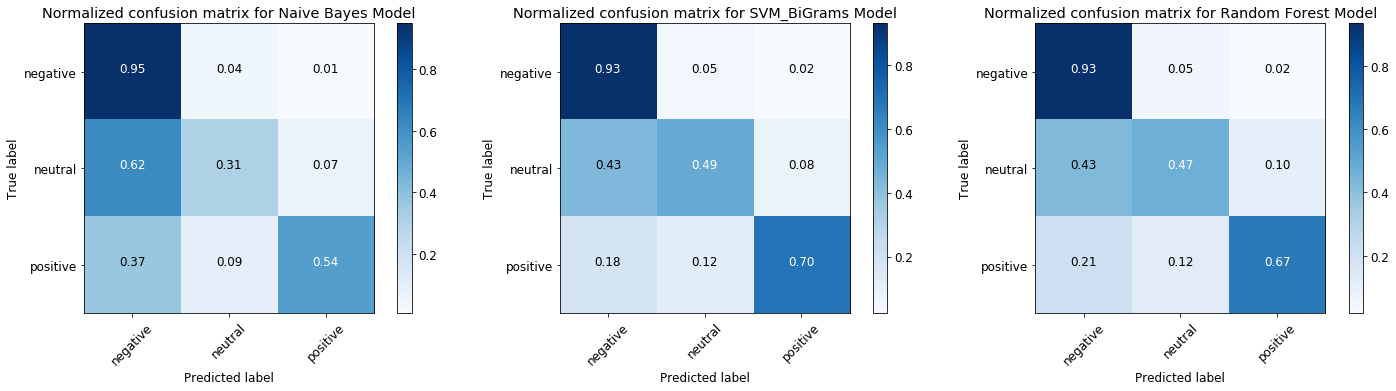

In [5]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='Normalized confusion matrix for Naive Bayes Model')

fig.add_subplot(3,3,2)
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM_BiGrams Model')

fig.add_subplot(3,3,3)
cnf_matrix = confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='Normalized confusion matrix for Random Forest Model')
plt.show()

Comparing the confusion matrix for the three plots its clear that SVM model performs qualitatively better than the two others. For Naive Bayes, we see that 37% of positive tweets and 60% of neutral tweets are classified as negative class. Intuitively, the darker in this case the diagonal, better the model. In the SVM, for example, the rate of positive tweets being classified as negative are significantly lower (18%). 

**Note**: the SVM through cross-validation that achieved the best results were obtained using bi-grams.

Therefore, for these plots I would choose going with SVM model over the others. Now, let's see the confusion matrix for the deep learning models as well.

In [6]:
# loading deep learning predictions

y_pred_glove_100, y_test_glove_100 = np.load('data/y_pred_glove_100.npy'), np.load('data/y_test_glove_100.npy')
y_pred_glove_200, y_test_glove_200 = np.load('data/y_pred_glove_200.npy'), np.load('data/y_test_glove_200.npy')
y_pred_net_50, y_test_net_50 = np.load('data/y_pred_net_50.npy'), np.load('data/y_test_net_50.npy')

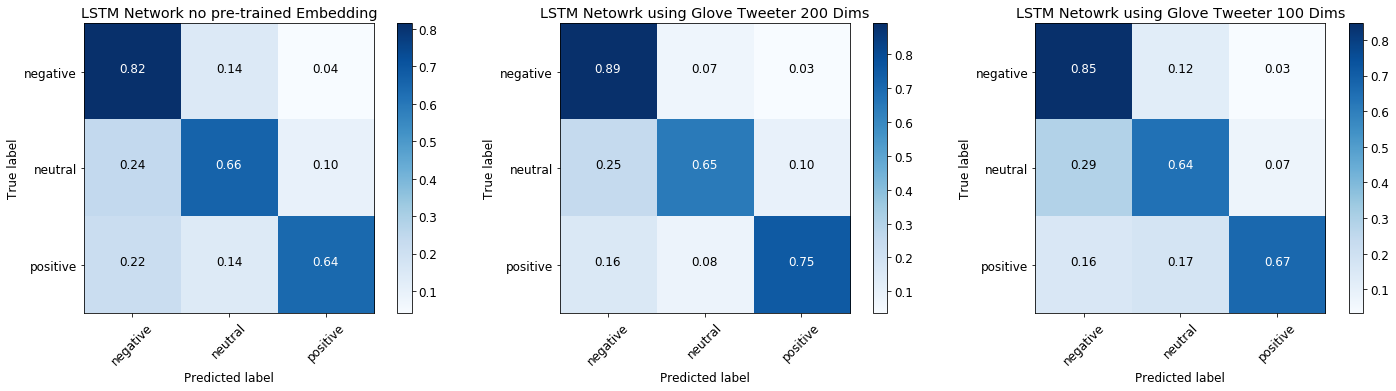

In [7]:
# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
cnf_matrix = confusion_matrix(y_test_net_50, y_pred_net_50)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='LSTM Network no pre-trained Embedding')

fig.add_subplot(3,3,2)
cnf_matrix = confusion_matrix(y_test_glove_200, y_pred_glove_200)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='LSTM Netowrk using Glove Tweeter 200 Dims')

fig.add_subplot(3,3,3)
cnf_matrix = confusion_matrix(y_test_glove_100, y_pred_glove_100)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positive'], normalize=True,
                      title='LSTM Netowrk using Glove Tweeter 100 Dims')
plt.show()

## Accuracy, Recall, Precision and F1-Scores

Since we have an unbalanced data set, that is, one class is predominant over others, rather than only using accuracy, it is important to check other metrics as well. In fact, depending on the case, they are even more valuable than accuracy.

In [8]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def scores(y_true, y_pred, name):
    avg_train_scores = precision_recall_fscore_support(y_true, y_pred, 
                                average = 'macro', 
                                labels = [0, 1, 2])
    scores_ = list(avg_train_scores)
    scores_.append(accuracy_score(y_true, y_pred))
    return pd.DataFrame(scores_, 
             columns = [name],
             index = ['precision', 'recall', 'fscore', 'distribution', 'accuracy'])

pd.concat([scores(y_test, y_pred_nb, 'Naive Bayes'), scores(y_test, y_pred_svm, 'SVM_BiGrams'), 
scores(y_test, y_pred_rf, 'RF')], axis = 1)

,Naive Bayes,SVM_BiGrams,RF
precision,0.728111,0.762473,0.753883
recall,0.600188,0.704799,0.691878
fscore,0.636028,0.727378,0.715583
distribution,NaN,NaN,NaN
accuracy,0.752475,0.801980,0.797030


In [9]:
pd.concat([scores(y_test_net_50, y_pred_net_50, 'LSTM Embeddings'), scores(y_test_glove_200, y_pred_glove_200, 'LSTM 200 Glove'), 
scores(y_test_glove_100, y_pred_glove_100, 'LSTM 100 Glove')], axis = 1)

,LSTM Embeddings,LSTM 200 Glove,LSTM 100 Glove
precision,0.694120,0.765474,0.720587
recall,0.706576,0.764491,0.719746
fscore,0.696783,0.764911,0.717539
distribution,NaN,NaN,NaN
accuracy,0.758865,0.824113,0.780142


We can see that LSTM performs above all other models, therefore being the best result achieved. Comparing the best two models SVM (with Bigrams) and LSTM, we can see that while SVM gets more correct labels on negative classes, LSTM performs worse but in exchange it correctly classifies better neutral an positive tweets. Moreover, it does not perform better based only on accuracy, fscore is significantly better than other models, comparing with SVM, we have 4% more, and in a business paradigm, this is not irrelevant.

To conclude, we can see that even though we did not extract features directly for the LSTM Network, it was able to perform the task above all other classical approaches, this could mean saving time in the feature creation process and also improving an ability of an analyst to work with a problem that he/she is not an expert.